# Quantum Time Series Analysis: Parallel Model (Problem)

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Aims
> *This script aims to create a parallel variational model to fit data and provide a forecast.*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/Dropbox/Dev/Python/qiskit/projects/ts/tqcebt_qtsa',
 '/home/jacob/anaconda3/envs/qiskit/lib/python38.zip',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/lib-dynload',
 '',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages/IPython/extensions',
 '/home/jacob/.ipython',
 '.']

In [2]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.jupyter import *

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils import *

In [3]:
debug = True

## Prepare data
*Values need to be in [0, 1] range*

<font color="red">Vary your data sets</font>
- <font color="red">Initially use the selected data set</font>
- <font color="red">Then see which data set gives the best / worst results</font>

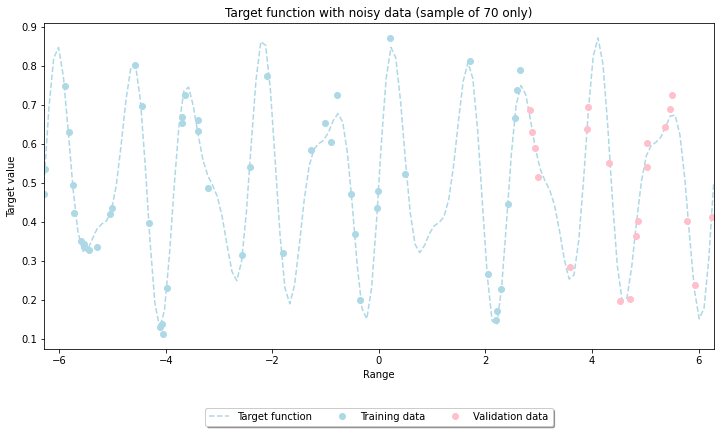

In [4]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples_train = 50
samples_valid = 20
samples = samples_train+samples_valid
samples_hi_res = samples*2
train_pc = samples_train / samples

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Collect target function parameters
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
y_all = f.fun(X_all)
X_train = (ub_train - lb_train) * algorithm_globals.random.random(samples_train) + lb_train
X_train = np.sort(X_train, axis = 0)
y_train = f.fun(X_train) + eps * (algorithm_globals.random.random(samples_train) - 0.5)
X_valid = (ub_valid - lb_valid) * algorithm_globals.random.random(samples_valid) + lb_valid
X_valid = np.sort(X_valid, axis = 0)
y_valid = f.fun(X_valid) + eps * (algorithm_globals.random.random(samples_valid) - 0.5)

### Reshape Xs for fitting, scoring and prediction
X_all = X_all.reshape(samples_hi_res, 1)
X_train = X_train.reshape(samples_train, 1)
X_valid = X_valid.reshape(samples_valid, 1)

### Plot target function and data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Target function with noisy data (sample of "+str(samples)+" only)")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.xlim(lb, ub)
# plt.ylim(f.yrange())

plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')
plt.plot(X_train, y_train, color='lightblue', marker='o', linestyle='None', label='Training data')
plt.plot(X_valid, y_valid, color='pink', marker='o', linestyle='None', label='Validation data')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=True)
plt.show()

## Create a parallel model to fit data

In [5]:
### Define quantum instance, fix random seeds to replicate results only, otherwise remove
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100, seed_simulator=2022, seed_transpiler=2022)

### Create a parallel model and test it

<font color="red">Your task is to implement a function which returns a parallel model cicuit, e.g.<br/>
a call to function parallel_fourier_model(3, 1, 2) would produce the following model:</font><br/><br/>
<img src="images/parallel_model_circuit_3_1_2.png" alt="Drawing"/>
<font color="red">Hint: To create an entanglement block, use TwoLocal ansatz.</font>

ParameterView([Parameter(A[0]), Parameter(A[10]), Parameter(A[11]), Parameter(A[12]), Parameter(A[13]), Parameter(A[14]), Parameter(A[15]), Parameter(A[16]), Parameter(A[17]), Parameter(A[18]), Parameter(A[19]), Parameter(A[1]), Parameter(A[20]), Parameter(A[21]), Parameter(A[22]), Parameter(A[23]), Parameter(A[24]), Parameter(A[25]), Parameter(A[26]), Parameter(A[2]), Parameter(A[3]), Parameter(A[4]), Parameter(A[5]), Parameter(A[6]), Parameter(A[7]), Parameter(A[8]), Parameter(A[9]), Parameter(B[0]), Parameter(B[10]), Parameter(B[11]), Parameter(B[12]), Parameter(B[13]), Parameter(B[14]), Parameter(B[15]), Parameter(B[16]), Parameter(B[17]), Parameter(B[1]), Parameter(B[2]), Parameter(B[3]), Parameter(B[4]), Parameter(B[5]), Parameter(B[6]), Parameter(B[7]), Parameter(B[8]), Parameter(B[9]), Parameter(x)])


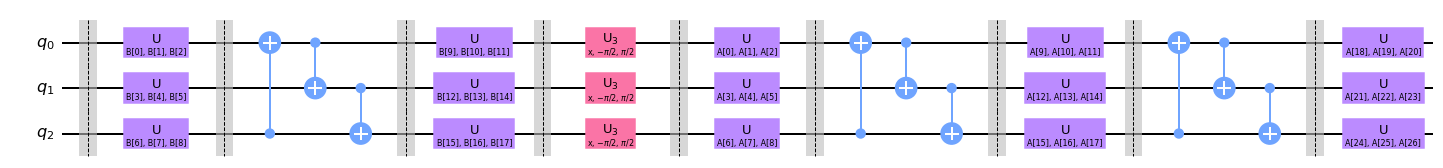

In [6]:
### Create a custom parallel model circuit 
#   - To be used with CircuitQNN / NeuralNetworkRegressor
#   qubit_no: The number of qubits in the circuit
#   before_layers: The number of trainable W layers before block S
#   after_layers: The number of trainable W layers after block S
#   returns: The parallel model circuit of WB layers, S block, WA layers

def parallel_fourier_model(qubit_no, before_layers, after_layers):
    
    # Your code goes here

    return ansatz    

# Sample parallel model with q qubits, BL layers before and BA layers after
# - Note that S block is identical for all qubits
m = parallel_fourier_model(3, 1, 2)

# Show all parameters, the last is X
print(m.parameters)

# Show the circuit
m.decompose().decompose().draw(output='mpl', fold=False, scale=1)

### Construct a model

<font color="red">Experiment by varying the following variables:</font>
- <font color="red">the function passed to "interpret" argument of regr_qnn (e.g. parity, first_only, your own)</font>
- <font color="red">the number of qubits to be used in the circuit</font>
- <font color="red">the number of layers before and after the S block</font>
- <font color="red">the weight initialisation vector</font>

In [7]:
# Start random process
algorithm_globals.random_seed = 2022

# Define our output
output_shape = 2
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2

# Define model parameters and their initial values (including random input)
qubits = 3 # 1 # 3 # 5 # 7 # more?
blayers = 1 # 3 # 5 # 7
alayers = 3 # 3 # 9 # 15 # 21 # 27 # 33
model = parallel_fourier_model(qubits, blayers, alayers)
init_weights = algorithm_globals.random.random((blayers+alayers+2)*qubits*3) * 2 * np.pi

# Construct QNN and show its circuit
regr_qnn = CircuitQNN(model, 
            input_params=[model.parameters[-1]], 
            weight_params=model.parameters[:-1], 
            interpret=parity,
            output_shape=output_shape,
            sparse=False,
            quantum_instance=quantum_instance)

print('Parallel model built')

Parallel model built


### Define a regressor
<font color="red">Experiment by varying the optimisers and their parameters</font>

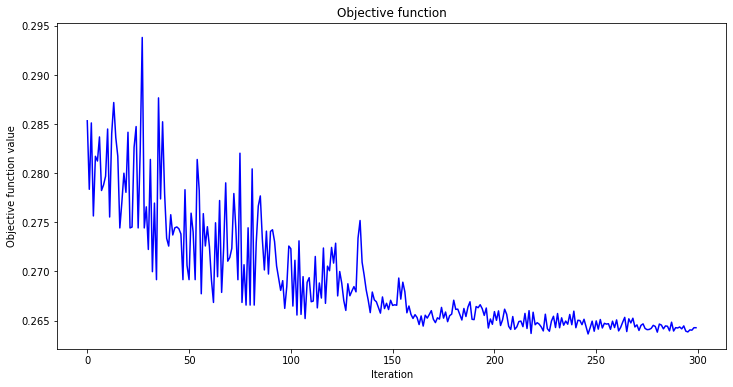

Minimum objective function value: (246, 0.2636307536458389)


In [8]:
### Define a regressor

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500) - very fast
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500) - slower
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16) - slowwweeer
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks
optimizer = COBYLA(maxiter=300)
regr_callback = Regr_callback(log_interval=20)
regr_callback.reset(obfun=[])

# Start the random process
algorithm_globals.random_seed = 2022

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss="squared_error",
    optimizer=optimizer, 
    initial_point=init_weights, 
    callback=regr_callback.collect # .graph # If wished to observe in real time
)

### Train the model

# Fit to data and plot progress
regressor.fit(X_train, y_train) 
regr_callback.plot()

### Find the optimum objective fun value and NN weights
print('Minimum objective function value:', regr_callback.min_obj())

## Score the model

In [9]:
### Calculate the score

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

yp_fun = np.array([yi for yi in f.fun(X_train)])
print('R2 for training data vs ground truth:\t', r2_score(yp_fun, y_train), '\n')

yp_train = np.array([[1-yi, yi] for yi in y_train])
yp_train_hat = np.array([y1 for y0, y1 in regressor.predict(X_train)])
print('R2 for pred vs training data:\t\t', regressor.score(X_train, yp_train))
print('MAPE for pred vs training data:\t\t', mean_absolute_percentage_error(y_train, yp_train_hat), '\n')

yp_valid = np.array([[1-yi, yi] for yi in y_valid])
yp_valid_hat = np.array([y1 for y0, y1 in regressor.predict(X_valid)])
print('R2 for pred vs validation data:\t\t', regressor.score(X_valid, yp_valid))
print('MAPE for pred vs validation data:\t', mean_absolute_percentage_error(y_valid, yp_valid_hat))

R2 for training data vs ground truth:	 0.9827475536429731 

R2 for pred vs training data:		 -0.5614108798409732
MAPE for pred vs training data:		 0.37042464136289605 

R2 for pred vs validation data:		 -0.3026769715596327
MAPE for pred vs validation data:	 0.45366343984141555


## Find the fit and predictions

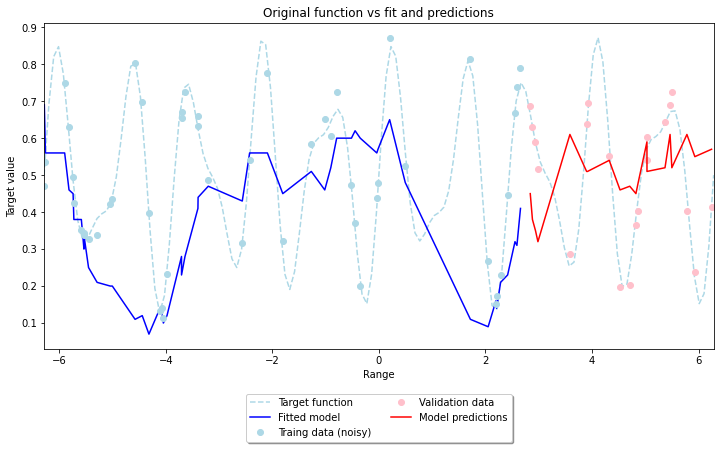

In [10]:
### Find predictions for the past and future data
yp_train_hat = regressor.predict(X_train)
yp_train_hat = np.array([yi[1] for yi in yp_train_hat])
yp_valid_hat = regressor.predict(X_valid)
yp_valid_hat = np.array([yi[1] for yi in yp_valid_hat])

# Prepare the plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original function vs fit and predictions")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.xlim(lb, ub)

# Plot target function
plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')

# Plot fitted line
# - Note that [P(-1),P(1)] is predicted
plt.plot(X_train, yp_train_hat, color='blue', label='Fitted model')

# Plot training data and predictions
plt.plot(X_train, y_train, color='lightblue', marker='o', linestyle='None', label='Traing data (noisy)')
plt.plot(X_valid, y_valid, color='pink', marker='o', linestyle='None', label='Validation data')
plt.plot(X_valid, yp_valid_hat, color='red', linestyle='solid', label='Model predictions')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

### <font color="red">Identify the best combinations of options and parameters</font>
- <font color="red">Can you beat the serial model?</font>
- <font color="red">Can you beat the presenter?</font>
- <font color="red">Which data set gives you the best/worst results?</font>

### Versions
- V8 (29/8/2022)
    - V8.9 - Prepared for the TQCEBT workshop as a demo

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table